# Effect of Price Variation on Purchase Probability

- **Our Goal is to measure effect of change in price has on purchase probabilities, In order to do that we would use the concept of Price Elasticity**

- **Elasticity is measured as change in the purchase probability per 1% increase in the price**
- -**To simulate purchase probabilities and to calculate elasticity of price we first need to model relationship between price and purchases for which we will be using Logistic regression**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [2]:
df_raw = pd.read_csv("df_final_seg.csv")

In [3]:
df = df_raw.drop("Unnamed: 0", axis=1)

In [4]:
df.head()

,ID,Day,Incidence,Brand,Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,...,Settlement size,segment,spent,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,rfm_segment,cluster_segment
0,200000001,1,0,0,0,1.59,1.87,2.01,2.09,2.66,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
1,200000001,11,0,0,0,1.51,1.89,1.99,2.09,2.66,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
2,200000001,12,0,0,0,1.51,1.89,1.99,2.09,2.66,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
3,200000001,16,0,0,0,1.52,1.89,1.98,2.09,2.66,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
4,200000001,18,0,0,0,1.52,1.89,1.99,2.09,2.66,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class


In [5]:
df["total_pices_mean"] = (( df['Price_1'] + df['Price_2'] +    df['Price_3'] +     df['Price_4'] +  df['Price_5'] )/5)

**As we are modelling for purchase across any brand, so let the price be the average across all the five brands**

In [6]:
X = pd.DataFrame( df["total_pices_mean"].values , columns=['Price'] ) 
y = df['Incidence']

In [7]:
from sklearn.linear_model import LogisticRegression
model_purch = LogisticRegression(solver = 'sag' , random_state=3)
model_purch.fit(X, y)

LogisticRegression(random_state=3, solver='sag')

In [8]:
print(model_purch.coef_)

[[-2.34793912]]


## Price Elasticity

**Formula**
```
Elasticity =  Beta * price(1-Probability(purchase) )
```

__Beta__: Model Coefficient

In [9]:
# We will simulate the prices for a range(min to max of our data), with an increase of 1%(as per defination of elasticity)
print(df[["Price_1", "Price_2", "Price_3", "Price_4", "Price_5"]].min())
print(df[["Price_1", "Price_2", "Price_3", "Price_4", "Price_5"]].max())


Price_1    1.10
Price_2    1.26
Price_3    1.87
Price_4    1.76
Price_5    2.11
dtype: float64
Price_1    1.59
Price_2    1.90
Price_3    2.14
Price_4    2.26
Price_5    2.80
dtype: float64


We will take the ranges from 0.5 to 3.5(as approx) with 1% increase between each value

In [10]:
price_rng = np.arange(0.5, 3.5, 0.01)
df_price_elast = pd.DataFrame(price_rng , columns=['price_range'])

In [11]:
preds = model_purch.predict_proba(df_price_elast["price_range"].values.reshape(-1 , 1))
prob_inci = preds[:][:, 1]
#Elasticity formula
prc_elast = model_purch.coef_[:, 0] * price_rng * (1 - prob_inci)

In [12]:
df_price_elast['price_elasticity'] = prc_elast
df_price_elast
      


,price_range,price_elasticity
0,0.50,-0.096407
1,0.51,-0.100475
2,0.52,-0.104670
3,0.53,-0.108996
4,0.54,-0.113454
...,...,...
295,3.45,-8.012488
296,3.46,-8.037737
297,3.47,-8.062951
298,3.48,-8.088132


Text(0.5, 1.0, 'Price Elasticity')

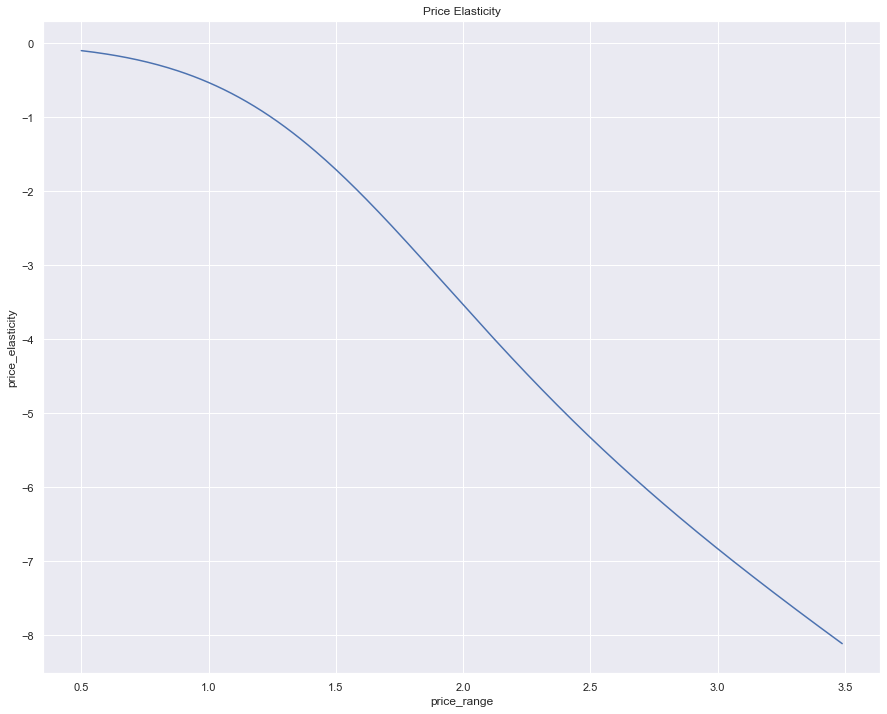

In [13]:
plt.figure(figsize = (15,12))
sns_plot = sns.lineplot(x = df_price_elast["price_range"], y = df_price_elast["price_elasticity"])
plt.title("Price Elasticity")

- **At Glance Plot makes sense, as price increases probability of purchase decreases**
- **As price increases elasticity decreases and all the elasticity values are negative indicating our above assertion to be true, Having said that we can clearly see some wiggle in the curve indicating that Elasticity clearly varies**
- **As we see Curve initially is not so steep indicating the change in the price at lower price ranges does not effect the purchase probability but as we go to higher price ranges line is steep indicating at high price range even slight increase increase or decrease in price has en effect on purchase probability**

- **The price is said to be significantly elastic or simply elastic when the absolute value of elasticity greater than 1 (<-1 in this case, as we are talking about absolute values) if not then we consider it to be inelastic, we can see that happening in the graph but not precisely so lets look in the dataframe**

- **As we see below that price is elastic from 1.25 indicating change in price of 1% from this price point will decrease our purchase probability by greater than 1%**

In [14]:
df_price_elast[abs(df_price_elast["price_elasticity"])>1]

,price_range,price_elasticity
75,1.25,-1.004714
76,1.26,-1.028447
77,1.27,-1.052544
78,1.28,-1.077002
79,1.29,-1.101822
...,...,...
295,3.45,-8.012488
296,3.46,-8.037737
297,3.47,-8.062951
298,3.48,-8.088132


## Segment Wise Analysis of Price Elasticity
- As we are going to be doing it to four segment Let us Create a function

In [15]:
def get_elastic_scores(df):
    X = pd.DataFrame( df["total_pices_mean"].values , columns=['Price'] ) 
    y = df['Incidence']
    
    model_purch = LogisticRegression(solver = 'sag' , random_state=3)
    model_purch.fit(X, y)
    
    price_rng = np.arange(0.5, 3.5, 0.01)
    df_price_elast = pd.DataFrame(price_rng , columns=['price_range'])
    
    preds = model_purch.predict_proba(df_price_elast["price_range"].values.reshape(-1 , 1))
    prob_inci = preds[:][:, 1]
    prc_elast = model_purch.coef_[:, 0] * price_rng * (1 - prob_inci)
    
    return prc_elast

In [16]:
df_price_elast["price_elasticity_wrkcls"] = get_elastic_scores(df[df['cluster_segment']=='Working Class'])
df_price_elast["price_elasticity_vtrns"] = get_elastic_scores(df[df['cluster_segment']=='veternes'])
df_price_elast["price_elasticity_urb"] = get_elastic_scores(df[df['cluster_segment']=='urbanites'])
df_price_elast["price_elasticity_whlsm"] = get_elastic_scores(df[df['cluster_segment']=='Wholesome'])

In [17]:
df_price_elast.head()

,price_range,price_elasticity,price_elasticity_wrkcls,price_elasticity_vtrns,price_elasticity_urb,price_elasticity_whlsm
0,0.50,-0.096407,-0.037125,-0.163484,-0.118226,-0.182706
1,0.51,-0.100475,-0.039177,-0.168253,-0.122440,-0.189016
2,0.52,-0.104670,-0.041326,-0.173090,-0.126751,-0.195458
3,0.53,-0.108996,-0.043575,-0.177995,-0.131161,-0.202035
4,0.54,-0.113454,-0.045928,-0.182968,-0.135670,-0.208747


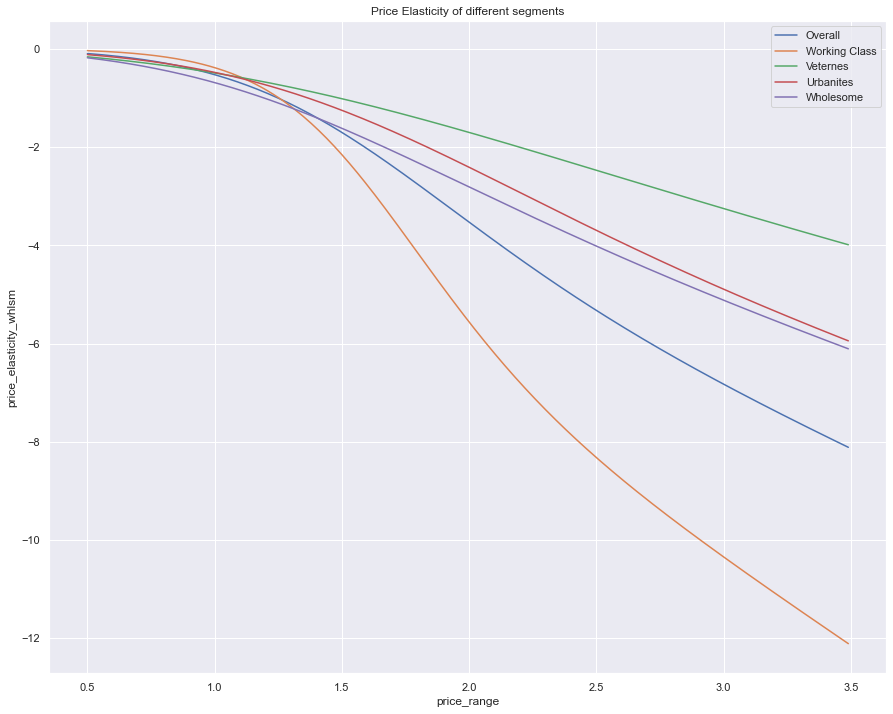

In [18]:
plt.figure(figsize = (15,12))
sns.lineplot(x = df_price_elast["price_range"], y = df_price_elast["price_elasticity"] , label='Overall')
sns.lineplot(x = df_price_elast["price_range"], y = df_price_elast["price_elasticity_wrkcls"] , label='Working Class')
sns.lineplot(x = df_price_elast["price_range"], y = df_price_elast["price_elasticity_vtrns"] , label='Veternes')
sns.lineplot(x = df_price_elast["price_range"], y = df_price_elast["price_elasticity_urb"] , label='Urbanites')
sns.lineplot(x = df_price_elast["price_range"], y = df_price_elast["price_elasticity_whlsm"] , label='Wholesome')
plt.title("Price Elasticity of different segments")
plt.show()

In [19]:
wrkcls_thresh =  round(df_price_elast[(abs(df_price_elast["price_elasticity_wrkcls"])>1)]["price_range"].iloc[0],3)
vtrns_thresh =  round(df_price_elast[(abs(df_price_elast["price_elasticity_vtrns"])>1)]["price_range"].iloc[0],3)
urb_thresh =  round(df_price_elast[(abs(df_price_elast["price_elasticity_urb"])>1)]["price_range"].iloc[0],3)
whlsm_thresh =  round(df_price_elast[(abs(df_price_elast["price_elasticity_whlsm"])>1)]["price_range"].iloc[0],3)

In [20]:
print(f"Threshold for Working Class: {wrkcls_thresh}")
print(f"Threshold for Veternes: {vtrns_thresh}")
print(f"Threshold for Urbanites: {urb_thresh}")
print(f"Threshold for Wholseome: {whlsm_thresh}")

Threshold for Working Class: 1.26
Threshold for Veternes: 1.49
Threshold for Urbanites: 1.37
Threshold for Wholseome: 1.2


## Analysis of elasticity with promotions as a feature
**As far as the modeling goes we just have to add another feature to our model making it a multivariate**
**During Generating predictions phase we can do it in two ways one with promotion  and one without instead of varying it across different brands(for simplicity)**

In [21]:
def get_elastic_scores_promotion(df , promotion_status):
    X = pd.DataFrame()
    X["Price"] = df["total_pices_mean"]
    X["promotin_status_mean"] = df['promotion_status_mean']
    y = df['Incidence']
    model_purch_promo = LogisticRegression(solver = 'sag' , random_state=3)
    model_purch_promo.fit(X, y)
    
    price_rng = np.arange(0.5, 3.5, 0.01)
    df_price_elast = pd.DataFrame(price_rng , columns=['price_range'])
    df_price_elast["promotion_status"] = promotion_status
    
    preds = model_purch_promo.predict_proba(df_price_elast[["price_range", "promotion_status"]])
    prob_inci = preds[:, 1]
    
    prc_elast = (model_purch_promo.coef_[:, 0] * price_rng) * (1 - prob_inci)
    return prc_elast

In [22]:
df['promotion_status_mean'] = (( df['Promotion_1'] + df['Promotion_2'] +    df['Promotion_3'] +     df['Promotion_4'] +  df['Promotion_5'] )/5)

### With Promotions Case

In [23]:
df_price_elast_prom1= pd.DataFrame()

In [24]:
df_price_elast_prom1["price_range"] = np.arange(0.5 , 3.5 , 0.01)

In [25]:
df_price_elast_prom1["overall"] = get_elastic_scores_promotion(df,1)
df_price_elast_prom1["price_elasticity_wrkcls"] = get_elastic_scores_promotion(df[df['cluster_segment']=='Working Class'],1)
df_price_elast_prom1["price_elasticity_vtrns"] = get_elastic_scores_promotion(df[df['cluster_segment']=='veternes'],1)
df_price_elast_prom1["price_elasticity_urb"] = get_elastic_scores_promotion(df[df['cluster_segment']=='urbanites'],1)
df_price_elast_prom1["price_elasticity_whlsm"] = get_elastic_scores_promotion(df[df['cluster_segment']=='Wholesome'],1)


In [26]:
df_price_elast_prom1.head()

,price_range,overall,price_elasticity_wrkcls,price_elasticity_vtrns,price_elasticity_urb,price_elasticity_whlsm
0,0.50,-0.125739,-0.062018,-0.121018,-0.123015,-0.126953
1,0.51,-0.129855,-0.064812,-0.123926,-0.126640,-0.129942
2,0.52,-0.134050,-0.067703,-0.126853,-0.130319,-0.132949
3,0.53,-0.138326,-0.070695,-0.129801,-0.134052,-0.135974
4,0.54,-0.142682,-0.073791,-0.132768,-0.137840,-0.139016


In [27]:
overall_prom1 = round(df_price_elast[(abs(df_price_elast_prom1["overall"])>1)]["price_range"].iloc[0],3)
wrkcls_thresh_prom1 =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_wrkcls"])>1)]["price_range"].iloc[0],3)
vtrns_thresh_prom1 =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_vtrns"])>1)]["price_range"].iloc[0],3)
urb_thresh_prom1 =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_urb"])>1)]["price_range"].iloc[0],3)
whlsm_thresh_prom1 =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_whlsm"])>1)]["price_range"].iloc[0],3)

In [28]:
print(f"Threshold for overall dataset: {overall_prom1}")
print(f"Threshold for Working Class: {wrkcls_thresh_prom1}")
print(f"Threshold for Veternes: {vtrns_thresh_prom1}")
print(f"Threshold for Urbanites: {urb_thresh_prom1}")
print(f"Threshold for Wholseome: {whlsm_thresh_prom1}")

Threshold for overall dataset: 1.46
Threshold for Working Class: 1.33
Threshold for Veternes: 2.36
Threshold for Urbanites: 1.67
Threshold for Wholseome: 2.4


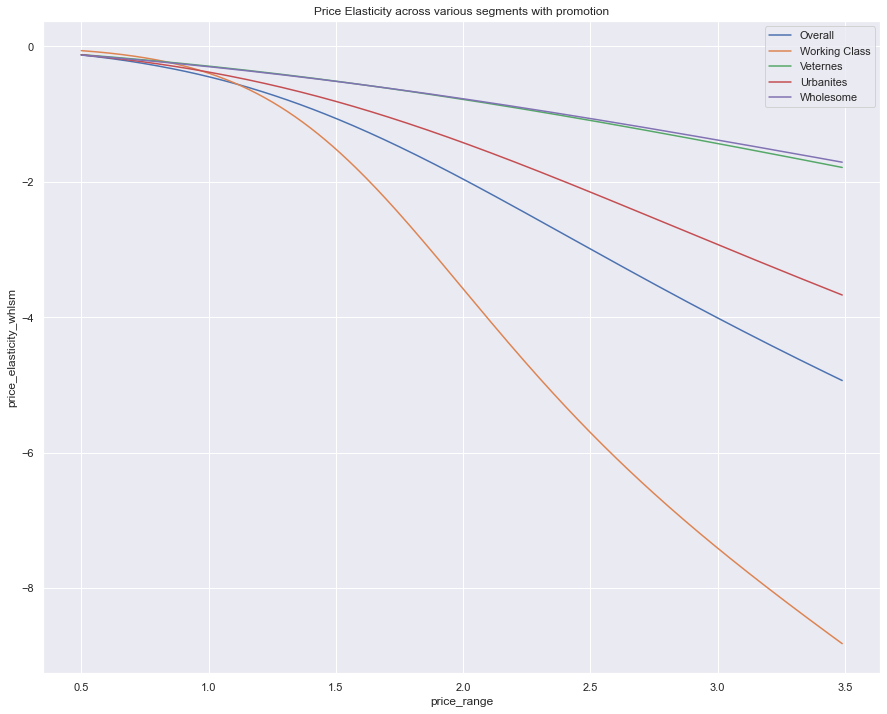

In [29]:
plt.figure(figsize = (15,12))
sns.lineplot(x = df_price_elast_prom1["price_range"], y = df_price_elast_prom1["overall"] , label='Overall')
sns.lineplot(x = df_price_elast_prom1["price_range"], y = df_price_elast_prom1["price_elasticity_wrkcls"] , label='Working Class')
sns.lineplot(x = df_price_elast_prom1["price_range"], y = df_price_elast_prom1["price_elasticity_vtrns"] , label='Veternes')
sns.lineplot(x = df_price_elast_prom1["price_range"], y = df_price_elast_prom1["price_elasticity_urb"] , label='Urbanites')
sns.lineplot(x = df_price_elast_prom1["price_range"], y = df_price_elast_prom1["price_elasticity_whlsm"] , label='Wholesome')
plt.title("Price Elasticity across various segments with promotion")
plt.show()

### Without Promotion

In [30]:
df_price_elast_promo = pd.DataFrame()

In [31]:
df_price_elast_promo["price_range"] = np.arange(0.5 , 3.5 , 0.01)

In [32]:
df_price_elast_promo["overall"] = get_elastic_scores_promotion(df,0)
df_price_elast_promo["price_elasticity_wrkcls"] = get_elastic_scores_promotion(df[df['cluster_segment']=='Working Class'],0)
df_price_elast_promo["price_elasticity_vtrns"] = get_elastic_scores_promotion(df[df['cluster_segment']=='veternes'],0)
df_price_elast_promo["price_elasticity_urb"] = get_elastic_scores_promotion(df[df['cluster_segment']=='urbanites'],0)
df_price_elast_promo["price_elasticity_whlsm"] = get_elastic_scores_promotion(df[df['cluster_segment']=='Wholesome'],0)


In [33]:
df_price_elast_promo.head()

,price_range,overall,price_elasticity_wrkcls,price_elasticity_vtrns,price_elasticity_urb,price_elasticity_whlsm
0,0.50,-0.195648,-0.114463,-0.154925,-0.168125,-0.192134
1,0.51,-0.201770,-0.119492,-0.158540,-0.172923,-0.196401
2,0.52,-0.207993,-0.124688,-0.162175,-0.177784,-0.200684
3,0.53,-0.214321,-0.130054,-0.165831,-0.182709,-0.204983
4,0.54,-0.220752,-0.135595,-0.169507,-0.187699,-0.209297


In [34]:
overall_promo =  round(df_price_elast[(abs(df_price_elast_prom1["overall"])>1)]["price_range"].iloc[0],3)
wrkcls_thresh_promo =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_wrkcls"])>1)]["price_range"].iloc[0],3)
vtrns_thresh_promo =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_vtrns"])>1)]["price_range"].iloc[0],3)
urb_thresh_promo =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_urb"])>1)]["price_range"].iloc[0],3)
whlsm_thresh_promo =  round(df_price_elast[(abs(df_price_elast_prom1["price_elasticity_whlsm"])>1)]["price_range"].iloc[0],3)

In [35]:
print(f"Threshold for Working Class: {overall_promo}")
print(f"Threshold for Working Class: {wrkcls_thresh_promo}")
print(f"Threshold for Veternes: {vtrns_thresh_promo}")
print(f"Threshold for Urbanites: {urb_thresh_promo}")
print(f"Threshold for Wholseome: {whlsm_thresh_promo}")

Threshold for Working Class: 1.46
Threshold for Working Class: 1.33
Threshold for Veternes: 2.36
Threshold for Urbanites: 1.67
Threshold for Wholseome: 2.4


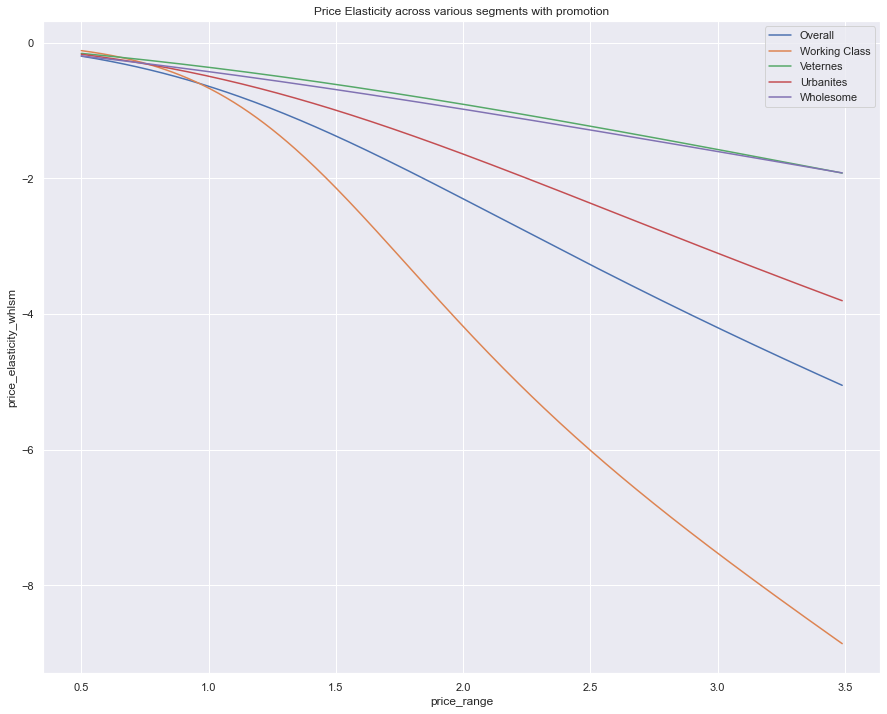

In [36]:
plt.figure(figsize = (15,12))
sns.lineplot(x = df_price_elast_promo["price_range"], y = df_price_elast_promo["overall"] , label='Overall')
sns.lineplot(x = df_price_elast_promo["price_range"], y = df_price_elast_promo["price_elasticity_wrkcls"] , label='Working Class')
sns.lineplot(x = df_price_elast_promo["price_range"], y = df_price_elast_promo["price_elasticity_vtrns"] , label='Veternes')
sns.lineplot(x = df_price_elast_promo["price_range"], y = df_price_elast_promo["price_elasticity_urb"] , label='Urbanites')
sns.lineplot(x = df_price_elast_promo["price_range"], y = df_price_elast_promo["price_elasticity_whlsm"] , label='Wholesome')
plt.title("Price Elasticity across various segments with promotion")
plt.show()

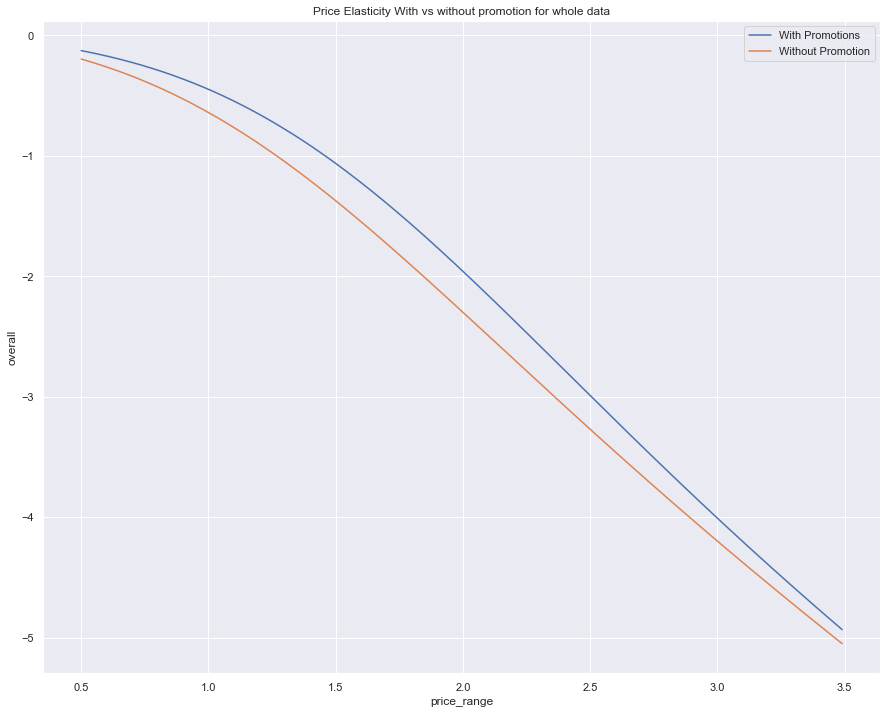

In [37]:
plt.figure(figsize = (15,12))
sns.lineplot(x = df_price_elast_prom1["price_range"], y = df_price_elast_prom1["overall"] , label='With Promotions')
sns.lineplot(x = df_price_elast_promo["price_range"], y = df_price_elast_promo["overall"] , label='Without Promotion')
plt.title("Price Elasticity With vs without promotion for whole data")
plt.show()

In [38]:
print(f"With Promotion Threshold: {overall_prom1}")
print(f"Without Promotion Threshold: {overall_promo}")

With Promotion Threshold: 1.46
Without Promotion Threshold: 1.46


## Observation


### Elasticity
**We can see that working class segment is the most sensitive to price changes, with veterans being the least**
**If we look closely we can see that at lower price range working class actually seems less sensitive to increase in price compared to all the other but it immediately decreases(increasing the sensitivity) as price increases**
**Though the threshold's(from which elasticity of each segment starts being significant) are very close to each other but are representative of the above graphs**

### Conclusion
**These insights are actionable in the context of say running say a promotion for sale, when we have limited resources without the analysis we would allocate equal resources for all segment but after these insights, we can increase the budget of working class people at the expense of veterans as price sensitivity of working class people is high(meaning there purchasing patterns are highly correlated to the prices in relative terms) and elasticity(price sensitivity of vetrans is lower meaning discounts are less likely to effect their buying pattern(again relative speaking)**

**We can observe less threshold in the case of promotion and a greater threshold in the case of no promotion, it speaks a lot about customers mentality(psychology) to be less effected by increased prices when the store claims to have a discount, may this is the reason why most of the times prior to increasing the price of a product, companies usually propose to be selling the product at discounted price (but in fact its the same price, what they mean to say is after the sale the price of the product is going to increase by current rate at which it being discounted)**

# Cross Brand Elasticity

In [39]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [41]:
df_raw = pd.read_csv("df_final_seg.csv")
df = df_raw.copy()

In [42]:
df.head()

,Unnamed: 0,ID,Day,Incidence,Brand,Quantity,Price_1,Price_2,Price_3,Price_4,...,Settlement size,segment,spent,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,rfm_segment,cluster_segment
0,0,200000001,1,0,0,0,1.59,1.87,2.01,2.09,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
1,1,200000001,11,0,0,0,1.51,1.89,1.99,2.09,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
2,2,200000001,12,0,0,0,1.51,1.89,1.99,2.09,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
3,3,200000001,16,0,0,0,1.52,1.89,1.98,2.09,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class
4,4,200000001,18,0,0,0,1.52,1.89,1.99,2.09,...,0,Working Class,0.0,0,0,0,0,0,Potential Loyalist,Working Class


- **We can compare any two brand, let us compare brand_2 and brand_1 as this pair seems to be interesting because except for brand_2 in all other brands champion customers have highest per person purchases and the reason to choose brand_1 is because as we discussed earlier brands are in the chronological order of their prices and given no other information than prices it would be rational to assume that the brand just above or below your price is the competition, so it could be brand_1 or brand_3 we choose band_1 because it has wider spread of purchases between segments which would make it interesting to see how it effects the segments, we will consider brand-2 to be "ours" and brand-1 as our competitor**
- **First let us first train the model on all the brands**
- **As we are focusing on brand choice (ie: if the purchase is being made then which brand is it going to be) rather than if the purchase is being made or not, so let us select rows only where a purchase is made irrespective of the brand**


In [43]:
df_brand_ch = df[df['Incidence']==1]

In [44]:
X = pd.DataFrame(df_brand_ch[["Price_1", "Price_2", "Price_3", "Price_4", "Price_5"]])
y = df_brand_ch["Brand"]

In [45]:
from sklearn.linear_model import LogisticRegression
model_brand  = LogisticRegression(random_state=3 , solver = 'sag', multi_class = 'multinomial')
model_brand.fit(X , y)

LogisticRegression(multi_class='multinomial', random_state=3, solver='sag')

In [46]:
df_brand_comp = pd.DataFrame()
prc_rng = np.arange(0.5 , 3.5 , 0.01)
df_brand_comp["price_range"] = prc_rng


In [47]:
def get_elastic_scores_brnd_ch(df, model, brand ):
    prc_rng = np.arange(0.5 , 3.5 , 0.01)
    prob = model.predict_proba(df)
    prob_brand = prob[:][:,(brand-1)]
    return ( (model.coef_[(brand-1),(brand-1)]) * (prc_rng) * (1 -prob_brand) )
    
    

## Cross Brand-2 Elasticity
- **As we are trying to model prices of only brand 2, we will have to keep the prices of the remaining brands constant(let them be the mean of their corresponding prices)**


In [48]:
X_brand2= pd.DataFrame(index =prc_rng)

X_brand2["brand_1"] = df_brand_ch["Price_1"].mean()
X_brand2["brand_2"] =  prc_rng
X_brand2["brand_3"] = df_brand_ch["Price_3"].mean()
X_brand2["brand_4"] = df_brand_ch["Price_4"].mean()
X_brand2["brand_5"] = df_brand_ch["Price_5"].mean()

In [49]:
X_brand2

,brand_1,brand_2,brand_3,brand_4,brand_5
0.50,1.384559,0.50,2.006694,2.159658,2.654296
0.51,1.384559,0.51,2.006694,2.159658,2.654296
0.52,1.384559,0.52,2.006694,2.159658,2.654296
0.53,1.384559,0.53,2.006694,2.159658,2.654296
0.54,1.384559,0.54,2.006694,2.159658,2.654296
...,...,...,...,...,...
3.45,1.384559,3.45,2.006694,2.159658,2.654296
3.46,1.384559,3.46,2.006694,2.159658,2.654296
3.47,1.384559,3.47,2.006694,2.159658,2.654296
3.48,1.384559,3.48,2.006694,2.159658,2.654296


In [50]:
df_brand_comp["own_b2"] = get_elastic_scores_brnd_ch(X_brand2 , model_brand , 2)

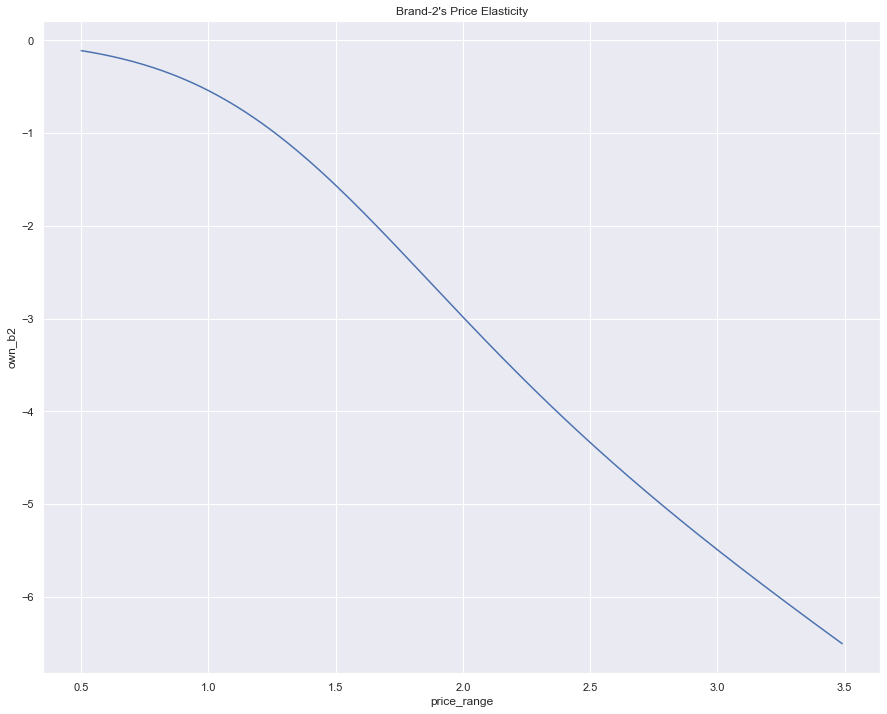

In [51]:
plt.figure(figsize = (15,12))
sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2"])
plt.title("Brand-2's Price Elasticity")
plt.show()

## Cross Price Elasticity of Brand 2 with  Cross Brand 1
**In here we are trying to get elasticity of Brand 1 to compare it with Brand 2, so the process wont change but the final formula of calculating the actual elasticity varies**

In [52]:
def get_elastic_scores_brnd_ch_cross(df, model, brand_m , brand_c ):
    prc_rng = np.arange(0.5 , 3.5 , 0.01)
    
    prob = model.predict_proba(df)
    
    prob_brand = prob[:][:,(brand_c-1)]
    
    beta = (-1*(model.coef_[(brand_m-1),(brand_m-1)]) )
    
    return (  (beta)* (prc_rng) * (prob_brand) )
    
    

In [53]:
X_brand1_cross= pd.DataFrame(index =prc_rng)
X_brand1_cross["brand_1"] =  prc_rng
X_brand1_cross["brand_2"] = df_brand_ch["Price_2"].mean()
X_brand1_cross["brand_3"] = df_brand_ch["Price_3"].mean()
X_brand1_cross["brand_4"] = df_brand_ch["Price_4"].mean()
X_brand1_cross["brand_5"] = df_brand_ch["Price_5"].mean()

In [54]:
X_brand1_cross.head()

,brand_1,brand_2,brand_3,brand_4,brand_5
0.50,0.50,1.764717,2.006694,2.159658,2.654296
0.51,0.51,1.764717,2.006694,2.159658,2.654296
0.52,0.52,1.764717,2.006694,2.159658,2.654296
0.53,0.53,1.764717,2.006694,2.159658,2.654296
0.54,0.54,1.764717,2.006694,2.159658,2.654296


In [55]:
df_brand_comp["cross_b1"] = get_elastic_scores_brnd_ch_cross(X_brand1_cross , model_brand , 2,1)

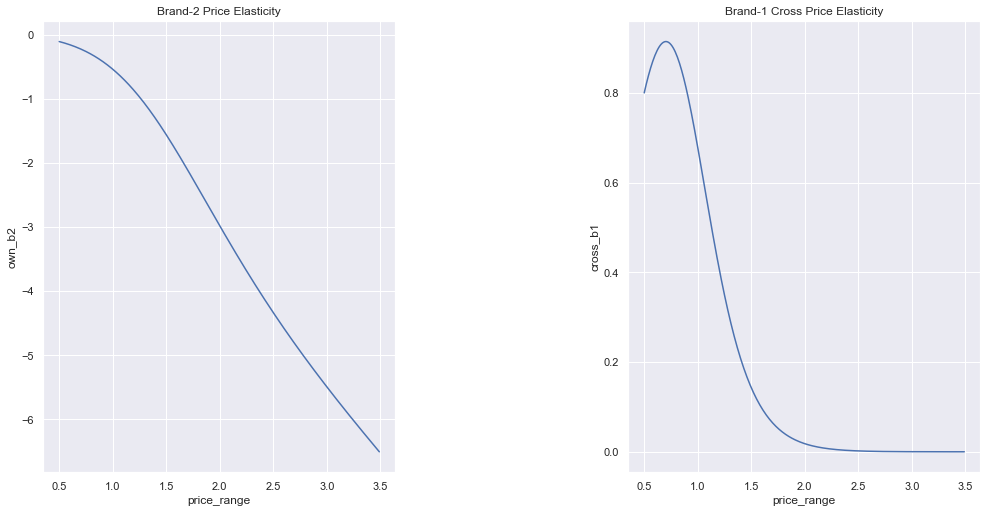

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.5)
fig.set_figheight(10)
fig.set_figwidth(18)

splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2"] , ax=axes[0] , palette="Blues_d")
axes[0].set_title("Brand-2 Price Elasticity")

splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1"] , ax=axes[1] , palette="Blues_d")
axes[1].set_title("Brand-1 Cross Price Elasticity")


plt.show()
        

## Cross Price Elasticity of Brand 2 compared to Brand 1 across different segments

In [57]:
#Working Class
df_brand_ch_wrkcls = df_brand_ch[df_brand_ch["segment"]=="Working Class"]

X_brand2= pd.DataFrame(index =prc_rng)

X_brand2["brand_1"] = df_brand_ch_wrkcls["Price_1"].mean()
X_brand2["brand_2"] =  prc_rng
X_brand2["brand_3"] = df_brand_ch_wrkcls["Price_3"].mean()
X_brand2["brand_4"] = df_brand_ch_wrkcls["Price_4"].mean()
X_brand2["brand_5"] = df_brand_ch_wrkcls["Price_5"].mean()

df_brand_comp["own_b2_wrkcls"] = get_elastic_scores_brnd_ch(X_brand2 , model_brand , 2)


X_brand1_cross= pd.DataFrame(index =prc_rng)
X_brand1_cross["brand_1"] =  prc_rng
X_brand1_cross["brand_2"] = df_brand_ch_wrkcls["Price_2"].mean()
X_brand1_cross["brand_3"] = df_brand_ch_wrkcls["Price_3"].mean()
X_brand1_cross["brand_4"] = df_brand_ch_wrkcls["Price_4"].mean()
X_brand1_cross["brand_5"] = df_brand_ch_wrkcls["Price_5"].mean()

df_brand_comp["cross_b1_wrkcls"] = get_elastic_scores_brnd_ch_cross(X_brand1_cross , model_brand , 2 , 1)

In [58]:
#Wholesome
df_brand_ch_whlsm= df_brand_ch[df_brand_ch["segment"]=="Wholesome"]

X_brand2= pd.DataFrame(index =prc_rng)

X_brand2["brand_1"] = df_brand_ch_whlsm["Price_1"].mean()
X_brand2["brand_2"] =  prc_rng
X_brand2["brand_3"] = df_brand_ch_whlsm["Price_3"].mean()
X_brand2["brand_4"] = df_brand_ch_whlsm["Price_4"].mean()
X_brand2["brand_5"] = df_brand_ch_whlsm["Price_5"].mean()

df_brand_comp["own_b2_whlsm"] = get_elastic_scores_brnd_ch(X_brand2 , model_brand , 2)



X_brand1_cross= pd.DataFrame(index =prc_rng)
X_brand1_cross["brand_1"] =  prc_rng
X_brand1_cross["brand_2"] = df_brand_ch_whlsm["Price_2"].mean()
X_brand1_cross["brand_3"] = df_brand_ch_whlsm["Price_3"].mean()
X_brand1_cross["brand_4"] = df_brand_ch_whlsm["Price_4"].mean()
X_brand1_cross["brand_5"] = df_brand_ch_whlsm["Price_5"].mean()

df_brand_comp["cross_b1_whlsm"] = get_elastic_scores_brnd_ch_cross(X_brand1_cross , model_brand , 2 , 1)

In [59]:
#Veterens
df_brand_ch_vtrns = df_brand_ch[df_brand_ch["segment"]=="veternes"]

X_brand2= pd.DataFrame(index =prc_rng)

X_brand2["brand_1"] = df_brand_ch_vtrns["Price_1"].mean()
X_brand2["brand_2"] =  prc_rng
X_brand2["brand_3"] = df_brand_ch_vtrns["Price_3"].mean()
X_brand2["brand_4"] = df_brand_ch_vtrns["Price_4"].mean()
X_brand2["brand_5"] = df_brand_ch_vtrns["Price_5"].mean()

df_brand_comp["own_b2_vtrns"] = get_elastic_scores_brnd_ch(X_brand2 , model_brand , 2)

X_brand1_cross= pd.DataFrame(index =prc_rng)
X_brand1_cross["brand_1"] =  prc_rng
X_brand1_cross["brand_2"] = df_brand_ch_vtrns["Price_2"].mean()
X_brand1_cross["brand_3"] = df_brand_ch_vtrns["Price_3"].mean()
X_brand1_cross["brand_4"] = df_brand_ch_vtrns["Price_4"].mean()
X_brand1_cross["brand_5"] = df_brand_ch_vtrns["Price_5"].mean()

df_brand_comp["cross_b1_vtrns"] = get_elastic_scores_brnd_ch_cross(X_brand1_cross , model_brand , 2 , 1)

In [60]:
#Urbanites
df_brand_ch_urb = df_brand_ch[df_brand_ch["segment"]=="urbanites"]
X_brand2= pd.DataFrame(index =prc_rng)

X_brand2["brand_1"] = df_brand_ch_urb["Price_1"].mean()
X_brand2["brand_2"] =  prc_rng
X_brand2["brand_3"] = df_brand_ch_urb["Price_3"].mean()
X_brand2["brand_4"] = df_brand_ch_urb["Price_4"].mean()
X_brand2["brand_5"] = df_brand_ch_urb["Price_5"].mean()

df_brand_comp["own_b2_urb"] = get_elastic_scores_brnd_ch(X_brand2 , model_brand , 2)


X_brand1_cross= pd.DataFrame(index =prc_rng)
X_brand1_cross["brand_1"] =  prc_rng
X_brand1_cross["brand_2"] = df_brand_ch_urb["Price_2"].mean()
X_brand1_cross["brand_3"] = df_brand_ch_urb["Price_3"].mean()
X_brand1_cross["brand_4"] = df_brand_ch_urb["Price_4"].mean()
X_brand1_cross["brand_5"] = df_brand_ch_urb["Price_5"].mean()

df_brand_comp["cross_b1_urb"] = get_elastic_scores_brnd_ch_cross(X_brand1_cross , model_brand , 2 , 1)

/var/folders/vp/k70yvwj57vd00y1yn6zl3mkr0000gn/T/ipykernel_38453/1351723258.py:2: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(pad=3.5)


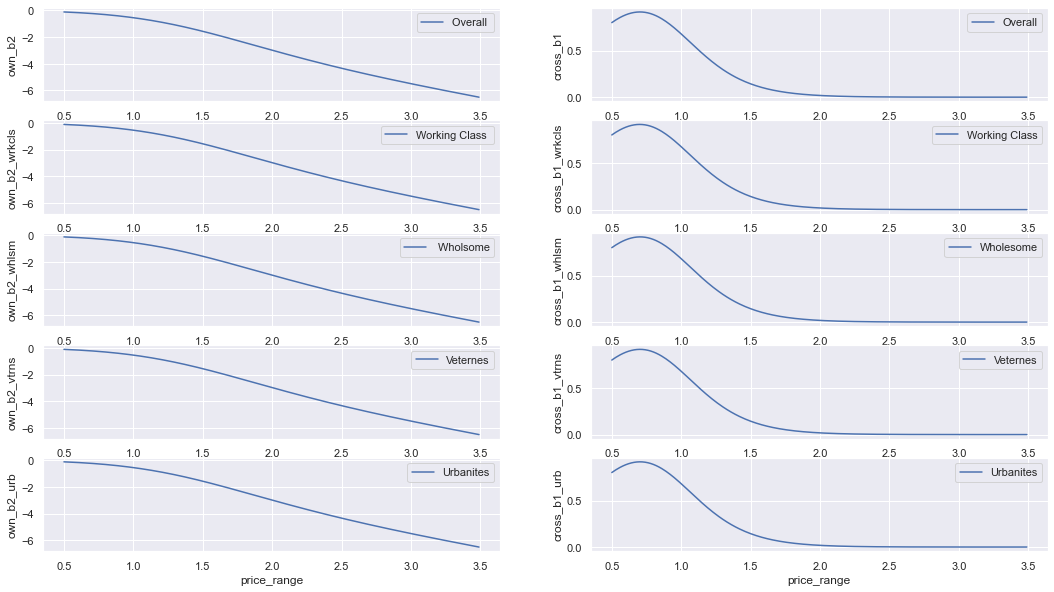

In [61]:
fig, axes = plt.subplots(nrows=5, ncols=2)
fig.tight_layout(pad=3.5)
fig.set_figheight(10)
fig.set_figwidth(18)

splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2"] , ax=axes[0,0] , palette="Blues_d" , label='Overall ')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_wrkcls"] , ax=axes[1,0] , palette="Blues_d", label='Working Class ')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_whlsm"] , ax=axes[2,0] , palette="Blues_d", label=' Wholsome')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_vtrns"] , ax=axes[3,0] , palette="Blues_d", label='Veternes')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_urb"] , ax=axes[4,0] , palette="Blues_d", label='Urbanites')


splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1"] , ax=axes[0,1] , palette="Blues_d", label='Overall')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_wrkcls"] , ax=axes[1,1] , palette="Blues_d", label='Working Class')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_whlsm"] , ax=axes[2,1] , palette="Blues_d", label='Wholesome')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_vtrns"] , ax=axes[3,1] , palette="Blues_d", label='Veternes')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_urb"] , ax=axes[4,1] , palette="Blues_d", label='Urbanites')


plt.show()
        

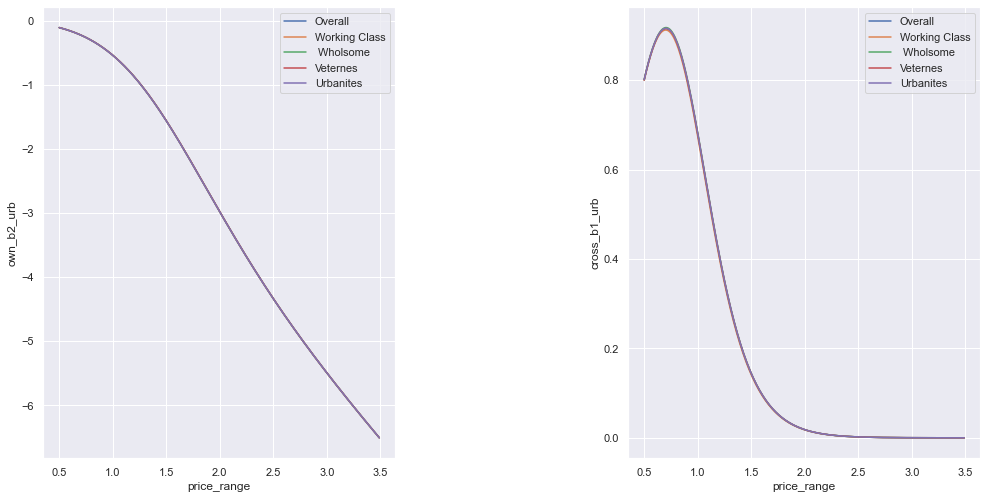

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.5)
fig.set_figheight(10)
fig.set_figwidth(18)

splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2"] , ax=axes[0] ,  label='Overall')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_wrkcls"] , ax=axes[0] ,  label='Working Class')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_whlsm"] , ax=axes[0] , label=' Wholsome')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_vtrns"] , ax=axes[0] , label='Veternes')
splot1 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["own_b2_urb"] , ax=axes[0] , label='Urbanites')


splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1"] , ax=axes[1] , label='Overall')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_wrkcls"] , ax=axes[1] ,  label='Working Class')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_whlsm"] , ax=axes[1] , label=' Wholsome')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_vtrns"] , ax=axes[1] , label='Veternes')
splot2 = sns.lineplot(df_brand_comp["price_range"] , df_brand_comp["cross_b1_urb"] , ax=axes[1] , label='Urbanites')


plt.show()
        

In [63]:
df_brand_comp.head()

,price_range,own_b2,cross_b1,own_b2_wrkcls,cross_b1_wrkcls,own_b2_whlsm,cross_b1_whlsm,own_b2_vtrns,cross_b1_vtrns,own_b2_urb,cross_b1_urb
0,0.50,-0.109600,0.800690,-0.109590,0.799570,-0.109527,0.801763,-0.109335,0.800721,-0.109857,0.800960
1,0.51,-0.114017,0.811043,-0.114007,0.809856,-0.113941,0.812173,-0.113741,0.811081,-0.114283,0.811331
2,0.52,-0.118559,0.820985,-0.118550,0.819728,-0.118482,0.822174,-0.118273,0.821031,-0.118835,0.821293
3,0.53,-0.123231,0.830504,-0.123223,0.829172,-0.123151,0.831753,-0.122933,0.830558,-0.123517,0.830832
4,0.54,-0.128035,0.839584,-0.128027,0.838176,-0.127953,0.840896,-0.127725,0.839647,-0.128330,0.839933


### Observation
- **On the left side graph we can visualize that as the price of brand 2 increases its purchase probability would decrease**
- **Where as on the right hand side plot we can visualize as the price of brand 1 increases sales of brand 2 increases(This is not just a coincidence but it is an indicative of the fact that both the brands belong to same category(candy) and impact each other's sales, this wouldn't be the case if we are trying to compare sales of candies and cars elasticity values would be pretty close to zero) the graph may decreasing but if we observe the elasticity values they are positive, its not just the relationship but elasticities help us quantify by how much do our profits increase/decrease due to variation of competitor's brand price**
- **If cross price elasticity are greater at points(which lie within the range of brand-2 price range) than our own brand elasticities then the cross brand can be classified as strong substitute(Strong Competitor)**
- **As far as the segments go it might seem looking at the plot that all segments have equal elastic values but as we can see above in the dataframe that is not the case, but the differences are so small that they hold no predictive signal, indicating that relationship between Brand-2 and Brand-1 do not significantly vary between different segments**

**Is brand 1 a strong substitute for brand 2 ?**

In [64]:
print(f"Min of Brand-2: {df['Price_2'].min()}")
print(f"Max of Brand-2: {df['Price_2'].max()}")

Min of Brand-2: 1.26
Max of Brand-2: 1.9


In [65]:
print(df_brand_comp[df_brand_comp['own_b2']<df_brand_comp['cross_b1']].shape)
print(df_brand_comp[df_brand_comp['own_b2_urb']<df_brand_comp['cross_b1_urb']].shape)
print(df_brand_comp[df_brand_comp['own_b2_vtrns']<df_brand_comp['cross_b1_vtrns']].shape)
print(df_brand_comp[df_brand_comp['own_b2_whlsm']<df_brand_comp['cross_b1_whlsm']].shape)
print(df_brand_comp[df_brand_comp['own_b2_wrkcls']<df_brand_comp['cross_b1_wrkcls']].shape)

(300, 11)
(300, 11)
(300, 11)
(300, 11)
(300, 11)


**As we can see cross elasticites of brand 1 are greater than brand 2 at every point and across every segment, so it would be statistically accuracte for us to consider that brand 1 is infact a competitor of brand 2**

## Finding the most competitive brand to Brand-2
**Before we dig into the purpose of cross price elasticity which we would in the next section, it would be helpful to find out which brand is the most competitive brand(ie: which brand is the customer more likely to prefer over our brand as an alternative)**

- **We will first calculate cross price elasticity of all the brands**
- **We will find out which brand has the highest cross elastic value between our brand's price range**

In [66]:
df_compe_brand2 = pd.DataFrame()
df_compe_brand2["price_range"] = df_brand_comp["price_range"]
df_compe_brand2["own_b2"]= df_brand_comp["own_b2"]
df_compe_brand2["cross_b1"]= df_brand_comp["cross_b1"]

In [67]:
# Brand-3
X_brand3_cross= pd.DataFrame(index =prc_rng)
X_brand3_cross["brand_1"] =  df_brand_ch["Price_1"].mean()
X_brand3_cross["brand_2"] = df_brand_ch["Price_2"].mean()
X_brand3_cross["brand_3"] = prc_rng
X_brand3_cross["brand_4"] = df_brand_ch["Price_4"].mean()
X_brand3_cross["brand_5"] = df_brand_ch["Price_5"].mean()
df_compe_brand2["cross_b3"]= get_elastic_scores_brnd_ch_cross(X_brand3_cross , model_brand, 2 , 3) 

In [68]:
# Brand-4
X_brand4_cross= pd.DataFrame(index =prc_rng)
X_brand4_cross["brand_1"] =  df_brand_ch["Price_1"].mean()
X_brand4_cross["brand_2"] = df_brand_ch["Price_2"].mean()
X_brand4_cross["brand_3"] = df_brand_ch["Price_3"].mean()
X_brand4_cross["brand_4"] = prc_rng
X_brand4_cross["brand_5"] = df_brand_ch["Price_5"].mean()
df_compe_brand2["cross_b4"]= get_elastic_scores_brnd_ch_cross(X_brand4_cross , model_brand ,  2 , 4) 

In [69]:
# Brand-5
X_brand5_cross= pd.DataFrame(index =prc_rng)
X_brand5_cross["brand_1"] =  df_brand_ch["Price_1"].mean()
X_brand5_cross["brand_2"] = df_brand_ch["Price_2"].mean()
X_brand5_cross["brand_3"] =  df_brand_ch["Price_3"].mean()
X_brand5_cross["brand_4"] = df_brand_ch["Price_4"].mean()
X_brand5_cross["brand_5"] = prc_rng
df_compe_brand2["cross_b5"]= get_elastic_scores_brnd_ch_cross(X_brand5_cross , model_brand ,  2 , 5) 

In [70]:
df_compe_brand2.head()

,price_range,own_b2,cross_b1,cross_b3,cross_b4,cross_b5
0,0.50,-0.109600,0.800690,0.005494,0.572600,0.855326
1,0.51,-0.114017,0.811043,0.005702,0.581700,0.871432
2,0.52,-0.118559,0.820985,0.005915,0.590701,0.887488
3,0.53,-0.123231,0.830504,0.006133,0.599603,0.903492
4,0.54,-0.128035,0.839584,0.006358,0.608407,0.919445


**As price range of brand-2 is 1.26 and 1.9 let's filter and find the difference between elastic and all other brand's cross elastic prices**

In [71]:
df_compe_brand2_intr  = df_compe_brand2[(df_compe_brand2["price_range"]>=1.26) & (df_compe_brand2["price_range"]<=1.9)]


In [72]:
brand1_comp  =   (df_compe_brand2_intr["cross_b1"] - df_compe_brand2_intr["own_b2"]).sum()
brand3_comp = (df_compe_brand2_intr["cross_b3"] - df_compe_brand2_intr["own_b2"]).sum()
brand4_comp = (df_compe_brand2_intr["cross_b4"] - df_compe_brand2_intr["own_b2"]).sum()
brand5_comp = (df_compe_brand2_intr["cross_b5"] - df_compe_brand2_intr["own_b2"]).sum()

In [73]:
print(f"Brand-1 competition: {brand1_comp}")
print(f"Brand-3 competition: {brand3_comp}")
print(f"Brand-4 competition: {brand4_comp}")
print(f"Brand-5 competition: {brand5_comp}")

Brand-1 competition: 122.77207531970302
Brand-3 competition: 120.87551505533415
Brand-4 competition: 176.48448336119696
Brand-5 competition: 247.07638299785313


- **The result suggests that Brand-5 is the closest competition**
- **But in real life it is unlikely to be the case, because all we are measuring to determine which is the most competitive is to forecast how would market share change if each brand decreases it's price by 1%, now the model which we are using to compute this is only using price as a feature which is to assume that price of the product is the only thing which drives our motivation to buy our product, it is definitely one of the factors but not the only one, our model is not considering the tendency of customer to buy the product which he/she always purchases and not measuring if customer taste aligns with the product our model assumes that the only thing which is stoping the customer from purchasing a product which he/she did not purchase is price (which is simply not the case)**
- **So relying on such a model blindly without domain knowledge about the actual brands is misleading, so let us assume for our case that competition to a brand can be either brand above it or below it, so in this case out of brand-3 and brand-1, brand-1 has higher value indicating it is more likely to be an alternative to our brand, so let us understand the relationship between our brand and brand-1**

## Quantifying Relationship between Brand-2 and Brand-1
**To understand the relationship in terms of market share let us consider a scenario where brand-1 decrease it's price by 1% when it's price is 1.39(as it is the mean price of brand-1) elasticity and cross elasticity values corresponding to 1.39 can give us an insight into how this discount would manifest itself in real world for both the brands**

In [74]:
df['Price_1'].mean()

1.3920743529893755

In [75]:
df_brand_comp[['price_range','own_b2','cross_b1']][df_brand_comp['price_range']>=1.39]

,price_range,own_b2,cross_b1
89,1.39,-1.286344,0.216066
90,1.40,-1.310389,0.208338
91,1.41,-1.334649,0.200839
92,1.42,-1.359119,0.193567
93,1.43,-1.383795,0.186518
...,...,...,...
295,3.45,-6.423637,0.000023
296,3.46,-6.443649,0.000022
297,3.47,-6.463637,0.000021
298,3.48,-6.483604,0.000020


- **cross elasticity value of Brand-1 corresponding to 1.39 indicate the factor by which our brand's(brand-2) purchase probability could decrease, so a decrease by 1% of brand-1 price would mean a decline of 0.2% purchase probability of brand-2**
- **We could counter that discount given by brand-1 by decreasing our brand's price by 1% in which case purchase probability of our brand would increase by 1.2%**
- **Which means as a strategic move to counter the 1% discount of price by brand-1 we discount our brand candy price by 1% then total we would have an increase of 1% purchase probability (as 1.2-0.2=1)**
- **If we wanted to find out by how much do we need to decrease our prices in order to counter the decrease of brand-1 then we can simply do (cross_elasticity/brand_elasticity), which is (0.2/1.2 = 0.16) so we need to discount our prices by 0.16% to retain the market share**
